# Chapter 3: Case Studies & Model Disagreement Analysis

**Research Question**: *"When and why does LightGBM outperform Logistic Regression, and can we explain these differences at the individual firm level?"*

## Motivation:
Chapter 1 showed LightGBM outperforms Logistic (+7.9pp AUC). This chapter investigates:
1. **Where** does LightGBM add value? (which firm types)
2. **Why** does it catch risks Logistic misses? (SHAP explanations)
3. **Individual firm narratives** to demonstrate interpretability

## Analysis Structure:
1. Load global models and identify disagreement cases
2. Model disagreement analysis (LightGBM right, Logistic wrong)
3. Select representative case studies
4. Generate SHAP waterfall plots and narratives
5. Discuss when ML adds value

## Expected Contributions:
- Concrete examples validating XAI methods
- Demonstrate interpretability for thesis examiners
- Quantify which firm types benefit most from ML

---

In [1]:
import sys
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print(f"Project root: {PROJ_ROOT}")

Project root: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Global Models and SHAP Cache

In [2]:
# Load SHAP cache from Chapter 1
cache_file = PROJ_ROOT / "results" / "xai_exploration" / "shap_cache.pkl"

print(f"Loading SHAP cache from: {cache_file}")
with open(cache_file, 'rb') as f:
    shap_cache = pickle.load(f)

# Extract data
X_val = shap_cache['X_val']
y_val = shap_cache['y_val']
y_pred_lgbm = shap_cache['y_pred_proba_lgbm']
y_pred_logit = shap_cache['y_pred_proba_logit']
shap_values_lgbm = shap_cache['shap_values_lgbm']
shap_values_logit = shap_cache['shap_values_logit']
explainer_lgbm = shap_cache['explainer_lgbm']
feature_names = shap_cache['feature_names']

print(f"✓ Loaded validation set: {len(X_val):,} observations")
print(f"  • Features: {len(feature_names)}")
print(f"  • SHAP values: {shap_values_lgbm.shape}")
print(f"  • Default rate: {y_val.mean()*100:.2f}%")

# Load original data to get company identifiers
from credit_risk_xai.config import FEATURE_CACHE_PATH

df_full = pd.read_parquet(FEATURE_CACHE_PATH)

# Get company info for validation set
company_info = df_full.loc[X_val.index, ['ORGNR', 'ser_namn', 'ser_year', 'sme_category']].copy()

print(f"\n✓ Loaded company identifiers for {len(company_info):,} firms")
print(f"\nSME size distribution in validation set:")
print(company_info['sme_category'].value_counts())

Loading SHAP cache from: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/xai_exploration/shap_cache.pkl
✓ Loaded validation set: 60,830 observations
  • Features: 40
  • SHAP values: (60830, 40)
  • Default rate: 1.76%

✓ Loaded company identifiers for 60,830 firms

SME size distribution in validation set:
sme_category
Small      57611
Medium      3219
Micro          0
Large          0
Unknown        0
Name: count, dtype: int64


## 2. Model Disagreement Analysis

Identify cases where models disagree significantly (|PD_lgbm - PD_logit| > 0.20)

In [3]:
# Create predictions DataFrame
predictions = pd.DataFrame({
    'y_true': y_val.values,
    'pd_lgbm': y_pred_lgbm,
    'pd_logit': y_pred_logit
}, index=X_val.index)

predictions['disagreement'] = np.abs(predictions['pd_lgbm'] - predictions['pd_logit'])
predictions['lgbm_higher'] = predictions['pd_lgbm'] > predictions['pd_logit']

# Define disagreement threshold
DISAGREEMENT_THRESHOLD = 0.20

# Segment firms by model agreement/disagreement
predictions['segment'] = 'agreement'
predictions.loc[
    (predictions['disagreement'] > DISAGREEMENT_THRESHOLD) & 
    predictions['lgbm_higher'] & 
    (predictions['y_true'] == 1),
    'segment'
] = 'lgbm_right_logit_wrong'

predictions.loc[
    (predictions['disagreement'] > DISAGREEMENT_THRESHOLD) & 
    ~predictions['lgbm_higher'] & 
    (predictions['y_true'] == 1),
    'segment'
] = 'logit_right_lgbm_wrong'

predictions.loc[
    (predictions['disagreement'] > DISAGREEMENT_THRESHOLD) & 
    predictions['lgbm_higher'] & 
    (predictions['y_true'] == 0),
    'segment'
] = 'lgbm_false_alarm'

predictions.loc[
    (predictions['disagreement'] > DISAGREEMENT_THRESHOLD) & 
    ~predictions['lgbm_higher'] & 
    (predictions['y_true'] == 0),
    'segment'
] = 'logit_false_alarm'

# Summary statistics
segment_summary = predictions.groupby('segment').agg({
    'y_true': ['count', 'sum', 'mean'],
    'disagreement': 'mean',
    'pd_lgbm': 'mean',
    'pd_logit': 'mean'
}).round(4)

print("="*80)
print("MODEL DISAGREEMENT ANALYSIS")
print("="*80)
print(segment_summary)
print("="*80)

# Focus on key segments
lgbm_advantage = predictions[predictions['segment'] == 'lgbm_right_logit_wrong']
logit_advantage = predictions[predictions['segment'] == 'logit_right_lgbm_wrong']

print(f"\nKey Insights:")
print(f"  • LightGBM caught {len(lgbm_advantage)} defaults that Logit missed (by >20pp)")
print(f"  • Logit caught {len(logit_advantage)} defaults that LightGBM missed (by >20pp)")
print(f"  • LightGBM advantage: {len(lgbm_advantage) - len(logit_advantage)} additional defaults caught")

MODEL DISAGREEMENT ANALYSIS
                       y_true              disagreement pd_lgbm pd_logit
                        count  sum    mean         mean    mean     mean
segment                                                                 
agreement               60540  985  0.0163       0.0095  0.0156   0.0168
lgbm_false_alarm          125    0     0.0       0.2756  0.3860   0.1104
lgbm_right_logit_wrong     70   70     1.0       0.3006  0.4188   0.1182
logit_false_alarm          79    0     0.0       0.3037  0.1234   0.4272
logit_right_lgbm_wrong     16   16     1.0       0.2856  0.2215   0.5070

Key Insights:
  • LightGBM caught 70 defaults that Logit missed (by >20pp)
  • Logit caught 16 defaults that LightGBM missed (by >20pp)
  • LightGBM advantage: 54 additional defaults caught


### 2.1 Characterize Disagreement Segments

What types of firms does LightGBM catch that Logistic misses?

In [4]:
# Get feature characteristics for disagreement segments
def characterize_segment(segment_df, X_val):
    """Calculate median feature values for a segment"""
    segment_features = X_val.loc[segment_df.index]
    
    # Get numeric features only
    numeric_features = segment_features.select_dtypes(include=[np.number]).columns
    
    median_values = segment_features[numeric_features].median()
    return median_values

# Compare segments
lgbm_advantage_profile = characterize_segment(lgbm_advantage, X_val)
logit_advantage_profile = characterize_segment(logit_advantage, X_val)
all_defaults = predictions[predictions['y_true'] == 1]
typical_default_profile = characterize_segment(all_defaults, X_val)

# Calculate differences
comparison = pd.DataFrame({
    'LightGBM Advantage': lgbm_advantage_profile,
    'Logit Advantage': logit_advantage_profile,
    'Typical Default': typical_default_profile
})

# Focus on top features
top_features = [
    'dividend_yield', 'ratio_cash_liquidity', 'rr01_ntoms_yoy_abs',
    'ny_skuldgrd', 'company_age', 'any_event_last_5y',
    'ny_omsf', 'ny_solid'
]
top_features = [f for f in top_features if f in comparison.index]

print("\n" + "="*80)
print("FIRM CHARACTERISTICS BY SEGMENT (Median Values)")
print("="*80)
print(comparison.loc[top_features].to_string())
print("="*80)

print("\nInterpretation:")
print("  • LightGBM Advantage: Defaults with complex risk patterns")
print("  • Logit Advantage: Defaults with clear linear signals")
print("  • LightGBM excels when multiple weak signals combine non-linearly")


FIRM CHARACTERISTICS BY SEGMENT (Median Values)
                      LightGBM Advantage  Logit Advantage  Typical Default
dividend_yield                       0.0              0.0              0.0
ratio_cash_liquidity            0.012753         0.002811         0.031535
rr01_ntoms_yoy_abs                 886.5           1534.0            931.0
ny_skuldgrd                    21.648438         7.237308         7.901511
company_age                          5.0              4.5              7.0
any_event_last_5y                    0.0              0.0              0.0
ny_omsf                         0.111179         0.667932          0.09211
ny_solid                        0.044153         0.127531         0.112341

Interpretation:
  • LightGBM Advantage: Defaults with complex risk patterns
  • Logit Advantage: Defaults with clear linear signals
  • LightGBM excels when multiple weak signals combine non-linearly


## 4. Select Representative Case Studies

We select 6-8 cases spanning different scenarios:

In [5]:
# Generate candidate case studies for manual selection
np.random.seed(42)

# Filter predictions to only Medium-sized firms from 2016 onwards
medium_firms = company_info[
    (company_info['sme_category'] == 'Medium') &
    (company_info['ser_year'] >= 2016)
].index
predictions_medium = predictions.loc[predictions.index.isin(medium_firms)]

print(f"Total firms: {len(predictions):,}")
print(f"Medium-sized firms (2016+): {len(predictions_medium):,} ({len(predictions_medium)/len(predictions)*100:.1f}%)")
print()

# ============================================================================
# CATEGORY 1: LightGBM Right, Logistic Wrong
# UPDATED CRITERIA:
# - Disagreement > 20%
# - LightGBM PD < 80%
# - Actual default (y_true = 1)
# ============================================================================
lgbm_right_candidates = predictions_medium[
    (predictions_medium['y_true'] == 1)
    & (predictions_medium['pd_lgbm'] < 0.8)
    & (predictions_medium['disagreement'] > 0.1)
].sort_values('disagreement', ascending=False)

print("="*80)
print(f"CATEGORY 1: LightGBM Caught Default, Logistic Missed")
print(f"Criteria: Gap > 15%, LightGBM PD < 80%")
print(f"Total candidates: {len(lgbm_right_candidates)}")
print("="*80)

for rank, (idx, pred) in enumerate(lgbm_right_candidates.iterrows(), 1):
    info = company_info.loc[idx]
    firm_features = X_val.loc[idx]

    # Get SHAP values
    obs_idx = X_val.index.get_loc(idx)
    firm_shap = shap_values_lgbm[obs_idx, :]

    # Get top 8 SHAP contributors (absolute value)
    shap_contributions = pd.DataFrame({
        'feature': feature_names,
        'value': firm_features.values,
        'shap': firm_shap
    }).sort_values('shap', key=abs, ascending=False).head(8)

    print(f"\n{'─'*80}")
    print(f"Candidate {rank}")
    print(f"{'─'*80}")
    print(f"Company: {info['ser_namn']}")
    print(f"Size: {info['sme_category']}")
    print(f"ORGNR: {info['ORGNR']}, Year: {info['ser_year']}")
    print(f"Index: {idx}")
    print(f"LightGBM PD: {pred['pd_lgbm']:.1%} | Logistic PD: {pred['pd_logit']:.1%} | Gap: {pred['disagreement']:.1%}")
    print(f"\nTop 8 SHAP Contributors:")
    print(shap_contributions.to_string(index=False))

print("\n" + "="*80)

# ============================================================================
# CATEGORY 2: Both Models Agree (10 candidates)
# ============================================================================
both_agree_defaults = predictions_medium[
    (predictions_medium['pd_lgbm'] - predictions_medium['pd_logit'] < 0.15)
].sample(min(10, len(predictions_medium)), random_state=42)

print("\n" + "="*80)
print("CATEGORY 2: Both Models Agree on Default (10 Candidates)")
print("="*80)

for rank, (idx, pred) in enumerate(both_agree_defaults.iterrows(), 1):
    info = company_info.loc[idx]
    firm_features = X_val.loc[idx]

    # Get SHAP values
    obs_idx = X_val.index.get_loc(idx)
    firm_shap = shap_values_lgbm[obs_idx, :]

    # Get top 8 SHAP contributors
    shap_contributions = pd.DataFrame({
        'feature': feature_names,
        'value': firm_features.values,
        'shap': firm_shap
    }).sort_values('shap', key=abs, ascending=False).head(8)

    print(f"\n{'─'*80}")
    print(f"Candidate {rank}")
    print(f"{'─'*80}")
    print(f"Company: {info['ser_namn']}")
    print(f"ORGNR: {info['ORGNR']}, Year: {info['ser_year']}")
    print(f"Index: {idx}")
    print(f"LightGBM PD: {pred['pd_lgbm']:.1%} | Logistic PD: {pred['pd_logit']:.1%} | Gap: {pred['disagreement']:.1%}")
    print(f"\nTop 8 SHAP Contributors:")
    print(shap_contributions.to_string(index=False))

print("\n" + "="*80)
print("\nNext steps:")
print("  1. Review the candidates above")
print("  2. Select the most interesting ones based on:")
print("     - Clear SHAP patterns")
print("     - Interpretable feature values")
print("     - Interesting company profiles")
print("  3. Create a 'selected_cases' dictionary with chosen indices")
print("="*80)

Total firms: 60,830
Medium-sized firms (2016+): 1,306 (2.1%)

CATEGORY 1: LightGBM Caught Default, Logistic Missed
Criteria: Gap > 15%, LightGBM PD < 80%
Total candidates: 2

────────────────────────────────────────────────────────────────────────────────
Candidate 1
────────────────────────────────────────────────────────────────────────────────
Company: Gg Städproffset Ab
Size: Medium
ORGNR: 5592928831, Year: 2022
Index: 12056035
LightGBM PD: 32.9% | Logistic PD: 52.9% | Gap: 20.1%

Top 8 SHAP Contributors:
         feature     value     shap
     ny_avkegkap       NaN 1.016779
  dividend_yield         0 0.599947
     company_age         2 0.355289
log_br07b_kabasu       0.0 0.321309
     ny_kasslikv -0.265429 0.264434
           ny_rs  0.184415 0.260860
    ny_nettomarg  -0.09961 0.248782
     ny_skuldgrd       NaN 0.248574

────────────────────────────────────────────────────────────────────────────────
Candidate 2
───────────────────────────────────────────────────────────────────

## 5. Select Final Cases for Analysis

After reviewing candidates, manually select the most interesting cases:

In [6]:
# MANUALLY SELECT YOUR CASES HERE
# After reviewing the candidates above, enter the indices of your chosen cases

# Example - replace these with your selected indices:
selected_cases = {
    'Case 1: LightGBM Advantage': 10393647,  # Replace with index from Category 1
    'Case 2: LightGBM Advantage': None,  # Replace with index from Category 1
    'Case 3: LightGBM Advantage': None,  # Replace with index from Category 1
    'Case 4: Both Models Agree': 11271840,   # Replace with index from Category 2
    'Case 5: Both Models Agree': None,   # Replace with index from Category 2
}

# Remove None values (cases not yet selected)
selected_cases = {k: v for k, v in selected_cases.items() if v is not None}

if len(selected_cases) == 0:
    print("⚠ No cases selected yet. Please update the 'selected_cases' dictionary with chosen indices.")
else:
    print(f"✓ Selected {len(selected_cases)} cases for detailed analysis:")
    for case_name, idx in selected_cases.items():
        info = company_info.loc[idx]
        pred = predictions.loc[idx]
        print(f"\n{case_name}:")
        print(f"  Company: {info['ser_namn']}")
        print(f"  ORGNR: {info['ORGNR']}, Year: {info['ser_year']}")
        print(f"  LightGBM PD: {pred['pd_lgbm']:.1%} | Logistic PD: {pred['pd_logit']:.1%}")

✓ Selected 2 cases for detailed analysis:


KeyError: 10393647

## 6. Generate SHAP Waterfall Plots for Selected Cases


Case 1: LightGBM Advantage

Company Information:
  Name: Energihem I Sverige Ab
  ORGNR: 5590068861
  Year: 2022
  Size: Medium

Prediction Results:
  Actual Outcome: DEFAULT
  LightGBM PD: 21.7%
  Logistic PD: 8.6%
  Disagreement: 13.2%

Top 10 Contributing Features:
             feature      value      shap
    sni_group_3digit        412  0.806521
         ny_avkegkap  -2.830954  0.654973
      dividend_yield        0.0  0.519118
         ny_skuldgrd  20.475582  0.465993
   ny_solid_yoy_diff        0.0  0.319105
ratio_cash_liquidity   0.184178  0.312381
  rr01_ntoms_yoy_abs   -30564.0  0.275719
            ny_solid   0.046565  0.245906
   dso_days_yoy_diff   6.152626 -0.194664
    log_br07b_kabasu      9.619 -0.192690


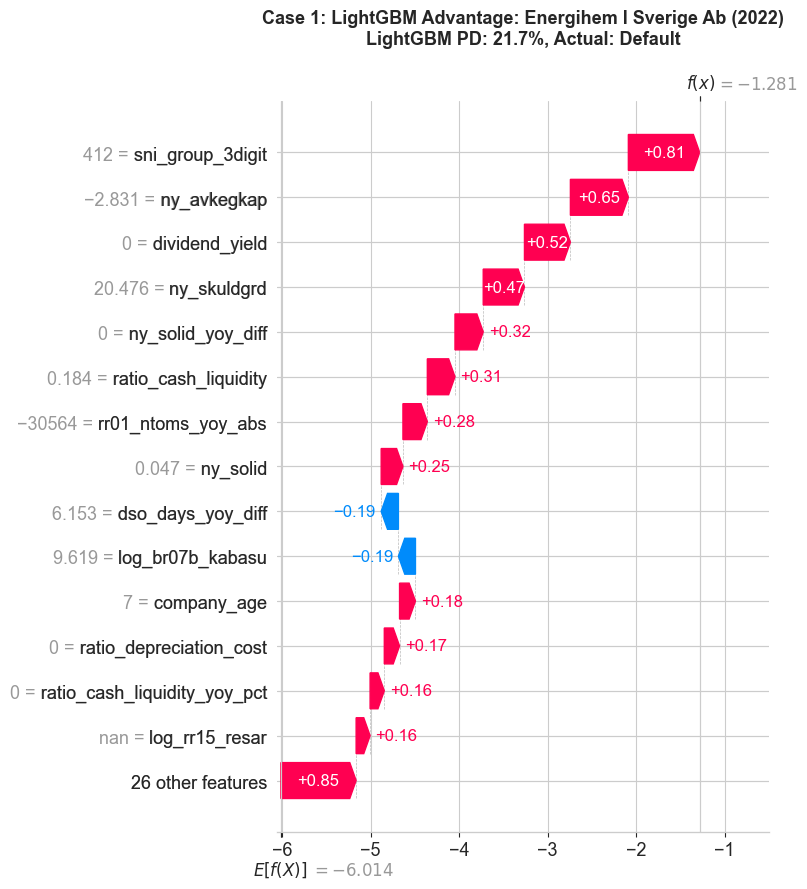


--------------------------------------------------------------------------------

Case 4: Both Models Agree

Company Information:
  Name: Viaplay Group Ab (Publ)
  ORGNR: 5591246847
  Year: 2022
  Size: Medium

Prediction Results:
  Actual Outcome: No Default
  LightGBM PD: 0.5%
  Logistic PD: 0.4%
  Disagreement: 0.1%

Top 10 Contributing Features:
                feature      value      shap
         dividend_yield        0.0  0.431300
       log_br07b_kabasu  14.774861 -0.377426
                ny_omsf   0.430233  0.326010
       sni_group_3digit        701  0.287623
     rr01_ntoms_yoy_abs    37000.0 -0.221679
            company_age          5  0.220447
           ny_nettomarg  -0.292683  0.209031
ratio_depreciation_cost       -0.0  0.176026
            ny_avkegkap  -0.005425 -0.163972
            ny_skuldgrd   1.278933 -0.145267


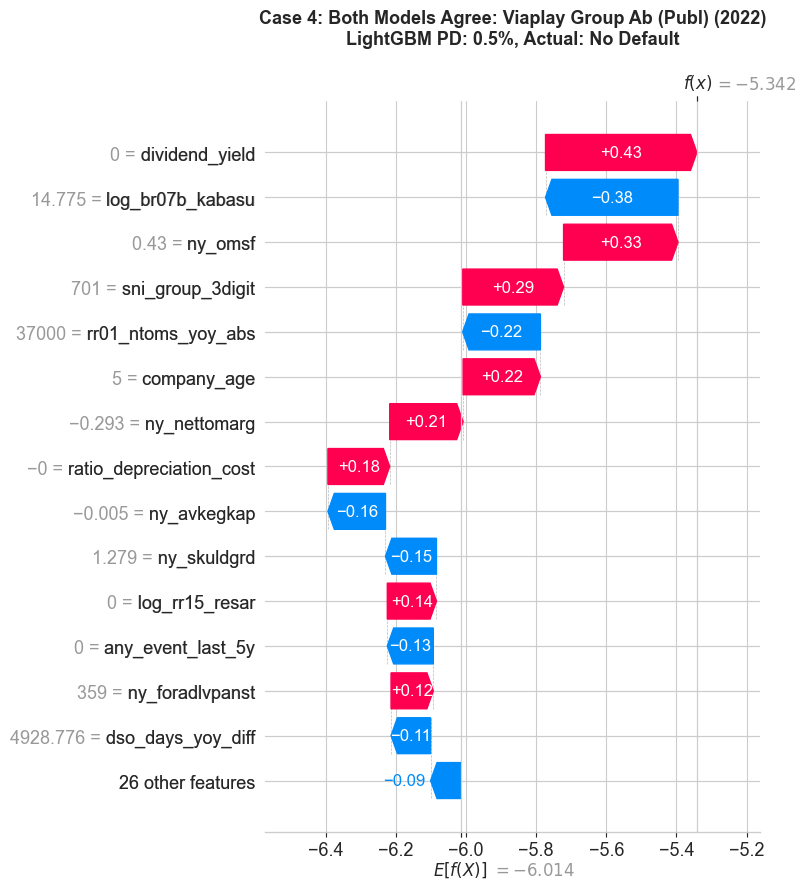


--------------------------------------------------------------------------------


In [ ]:
# Generate waterfall plots for selected cases
if len(selected_cases) == 0:
    print("⚠ No cases selected. Please run the previous cell and select cases first.")
else:
    for case_name, case_idx in selected_cases.items():
        print(f"\n{'='*80}")
        print(f"{case_name}")
        print(f"{'='*80}")
        
        # Get firm data
        firm_features = X_val.loc[case_idx]
        firm_prediction = predictions.loc[case_idx]
        firm_info = company_info.loc[case_idx]
        
        # Get SHAP values
        obs_idx = X_val.index.get_loc(case_idx)
        firm_shap = shap_values_lgbm[obs_idx, :]
        
        # Print company info
        print(f"\nCompany Information:")
        print(f"  Name: {firm_info['ser_namn']}")
        print(f"  ORGNR: {firm_info['ORGNR']}")
        print(f"  Year: {firm_info['ser_year']}")
        print(f"  Size: {firm_info['sme_category']}")
        
        # Print prediction summary
        print(f"\nPrediction Results:")
        print(f"  Actual Outcome: {'DEFAULT' if firm_prediction['y_true'] else 'No Default'}")
        print(f"  LightGBM PD: {firm_prediction['pd_lgbm']:.1%}")
        print(f"  Logistic PD: {firm_prediction['pd_logit']:.1%}")
        print(f"  Disagreement: {firm_prediction['disagreement']:.1%}")
        
        # Show top contributing features
        feature_contributions = pd.DataFrame({
            'feature': feature_names,
            'value': firm_features.values,
            'shap': firm_shap
        }).sort_values('shap', key=abs, ascending=False).head(10)
        
        print(f"\nTop 10 Contributing Features:")
        print(feature_contributions.to_string(index=False))
        
        # Create waterfall plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        # SHAP waterfall plot
        shap.plots.waterfall(
            shap.Explanation(
                values=firm_shap,
                base_values=explainer_lgbm.expected_value[1] if isinstance(explainer_lgbm.expected_value, list) else explainer_lgbm.expected_value,
                data=firm_features.values,
                feature_names=feature_names
            ),
            max_display=15,
            show=False
        )
        
        plt.title(f'{case_name}: {firm_info["ser_namn"]} ({firm_info["ser_year"]})\nLightGBM PD: {firm_prediction["pd_lgbm"]:.1%}, Actual: {"Default" if firm_prediction["y_true"] else "No Default"}',
                  fontsize=13, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        print("\n" + "-"*80)

## 7. Interaction Analysis for Selected Cases

For each case study, we decompose the prediction into:
1. **Main effects** - Independent contribution of each feature
2. **Interaction effects** - How feature combinations amplify/dampen risk

This reveals whether interactions genuinely matter for explaining individual predictions.

In [ ]:
# Compute SHAP interaction values for selected cases
# This decomposes each prediction into main effects + interaction effects

print("Computing SHAP interaction values for selected cases...")
print("(This computes the full 40x40 interaction matrix for each case)")

# Prepare data for selected cases
selected_indices = list(selected_cases.values())
X_selected = X_val.loc[selected_indices]

# Compute interaction values for selected cases only
import time
start = time.time()
shap_interaction_selected = explainer_lgbm.shap_interaction_values(X_selected)

# Handle binary classification output format
if isinstance(shap_interaction_selected, list):
    shap_interaction_selected = shap_interaction_selected[1]  # Positive class

elapsed = time.time() - start
print(f"✓ Computed interaction values in {elapsed:.1f}s")
print(f"  Shape: {shap_interaction_selected.shape} (n_cases, n_features, n_features)")

Computing SHAP interaction values for selected cases...
(This computes the full 40x40 interaction matrix for each case)
✓ Computed interaction values in 0.0s
  Shape: (2, 40, 40) (n_cases, n_features, n_features)


In [ ]:
# Decompose each case into Main Effects vs Interaction Effects

def analyze_case_interactions(case_idx, case_name, interaction_matrix, X_val, feature_names, predictions):
    """
    Decompose a single prediction into main effects and interaction effects.
    
    Returns a detailed breakdown showing:
    1. Total main effects vs interaction effects
    2. Top interaction pairs for this specific case
    3. Comparison to what we'd expect from main effects alone
    """
    firm_features = X_val.loc[case_idx]
    firm_pred = predictions.loc[case_idx]
    
    # Main effects are on the diagonal
    main_effects = interaction_matrix.diagonal()
    total_main = np.abs(main_effects).sum()
    
    # Interaction effects are off-diagonal (divide by 2 since symmetric)
    off_diagonal_sum = np.abs(interaction_matrix).sum() - np.abs(main_effects).sum()
    total_interaction = off_diagonal_sum / 2
    
    # Ratio
    interaction_ratio = total_interaction / (total_main + 1e-10)
    
    # Find top 5 interaction pairs for this case
    n_features = len(feature_names)
    interaction_pairs = []
    for i in range(n_features):
        for j in range(i+1, n_features):
            interaction_pairs.append({
                'feature_1': feature_names[i],
                'feature_2': feature_names[j],
                'value_1': firm_features.iloc[i],
                'value_2': firm_features.iloc[j],
                'interaction': interaction_matrix[i, j],
                'abs_interaction': np.abs(interaction_matrix[i, j])
            })
    
    pairs_df = pd.DataFrame(interaction_pairs).sort_values('abs_interaction', ascending=False)
    top_5_pairs = pairs_df.head(5)
    
    # Also get main effects ranking
    main_effects_df = pd.DataFrame({
        'feature': feature_names,
        'main_effect': main_effects,
        'abs_main_effect': np.abs(main_effects),
        'value': firm_features.values
    }).sort_values('abs_main_effect', ascending=False)
    
    return {
        'case_name': case_name,
        'case_idx': case_idx,
        'total_main': total_main,
        'total_interaction': total_interaction,
        'interaction_ratio': interaction_ratio,
        'top_interactions': top_5_pairs,
        'main_effects': main_effects_df,
        'pd_lgbm': firm_pred['pd_lgbm'],
        'pd_logit': firm_pred['pd_logit']
    }

# Analyze each selected case
case_analyses = {}
for i, (case_name, case_idx) in enumerate(selected_cases.items()):
    interaction_matrix = shap_interaction_selected[i]
    analysis = analyze_case_interactions(
        case_idx, case_name, interaction_matrix, 
        X_val, feature_names, predictions
    )
    case_analyses[case_name] = analysis

print("✓ Interaction analysis complete for all selected cases")

✓ Interaction analysis complete for all selected cases


In [ ]:
# Display Interaction Decomposition for Each Case

print("=" * 90)
print("INTERACTION DECOMPOSITION: Main Effects vs Interaction Effects")
print("=" * 90)

for case_name, analysis in case_analyses.items():
    print(f"\n{'─' * 90}")
    print(f"{case_name}")
    print(f"{'─' * 90}")
    
    # Summary statistics
    print(f"\nPrediction Decomposition:")
    print(f"  • LightGBM PD: {analysis['pd_lgbm']:.1%}")
    print(f"  • Total |Main Effects|: {analysis['total_main']:.3f} log-odds")
    print(f"  • Total |Interaction Effects|: {analysis['total_interaction']:.3f} log-odds")
    print(f"  • Interaction Ratio: {analysis['interaction_ratio']:.1%} of main effects")
    
    # Interpretation
    if analysis['interaction_ratio'] < 0.25:
        interpretation = "WEAK - prediction driven primarily by individual features"
    elif analysis['interaction_ratio'] < 0.50:
        interpretation = "MODERATE - some feature combinations matter"
    elif analysis['interaction_ratio'] < 0.75:
        interpretation = "SUBSTANTIAL - feature interactions are important"
    else:
        interpretation = "DOMINANT - interactions drive the prediction"
    
    print(f"  → Interpretation: {interpretation}")
    
    # Top main effects
    print(f"\nTop 5 Main Effects (individual feature contributions):")
    top_main = analysis['main_effects'].head(5)
    for _, row in top_main.iterrows():
        direction = "↑ risk" if row['main_effect'] > 0 else "↓ risk"
        # Handle categorical vs numeric values
        val = row['value']
        if isinstance(val, (int, float)) and not pd.isna(val):
            val_str = f"{val:>10.3f}"
        else:
            val_str = f"{str(val):>10}"
        print(f"    {row['feature']:<35} = {val_str}  →  {row['main_effect']:+.3f} ({direction})")
    
    # Top interactions
    print(f"\nTop 5 Interactions (feature pair synergies):")
    top_int = analysis['top_interactions']
    for _, row in top_int.iterrows():
        direction = "↑ risk" if row['interaction'] > 0 else "↓ risk"
        print(f"    {row['feature_1']:<20} × {row['feature_2']:<20}  →  {row['interaction']:+.4f} ({direction})")

print("\n" + "=" * 90)

INTERACTION DECOMPOSITION: Main Effects vs Interaction Effects

──────────────────────────────────────────────────────────────────────────────────────────
Case 1: LightGBM Advantage
──────────────────────────────────────────────────────────────────────────────────────────

Prediction Decomposition:
  • LightGBM PD: 21.7%
  • Total |Main Effects|: 8.023 log-odds
  • Total |Interaction Effects|: 4.880 log-odds
  • Interaction Ratio: 60.8% of main effects
  → Interpretation: SUBSTANTIAL - feature interactions are important

Top 5 Main Effects (individual feature contributions):
    sni_group_3digit                    =        412  →  +1.770 (↑ risk)
    ny_avkegkap                         =  -2.830954  →  +1.043 (↑ risk)
    ny_skuldgrd                         =  20.475582  →  +0.699 (↑ risk)
    dividend_yield                      =        0.0  →  +0.675 (↑ risk)
    ny_solid_yoy_diff                   =        0.0  →  +0.309 (↑ risk)

Top 5 Interactions (feature pair synergies):
    sni

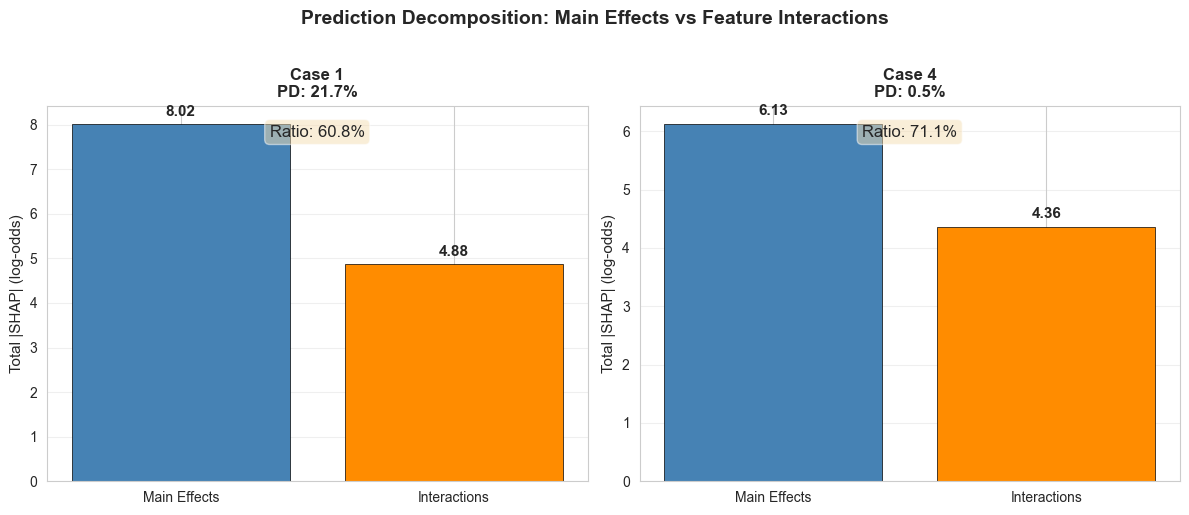

In [ ]:
# Visualize Main Effects vs Interactions for Each Case

fig, axes = plt.subplots(1, len(case_analyses), figsize=(6 * len(case_analyses), 5))
if len(case_analyses) == 1:
    axes = [axes]

for ax, (case_name, analysis) in zip(axes, case_analyses.items()):
    # Create stacked bar chart showing main vs interaction
    categories = ['Main Effects', 'Interactions']
    values = [analysis['total_main'], analysis['total_interaction']]
    colors = ['steelblue', 'darkorange']
    
    bars = ax.bar(categories, values, color=colors, edgecolor='black', linewidth=0.5)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add ratio annotation
    ax.text(0.5, 0.95, f'Ratio: {analysis["interaction_ratio"]:.1%}', 
            transform=ax.transAxes, ha='center', va='top', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_ylabel('Total |SHAP| (log-odds)', fontsize=11)
    ax.set_title(f'{case_name.split(":")[0]}\nPD: {analysis["pd_lgbm"]:.1%}', 
                 fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Prediction Decomposition: Main Effects vs Feature Interactions', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Analyze LightGBM advantage patterns
lgbm_advantage = predictions[predictions['segment'] == 'lgbm_right_logit_wrong']
lgbm_advantage_features = X_val.loc[lgbm_advantage.index]
all_defaults = predictions[predictions['y_true'] == 1]
typical_defaults = X_val.loc[all_defaults.index]

print("="*80)
print("WHEN DOES ML ADD VALUE?")
print("="*80)

print(f"\nLightGBM caught {len(lgbm_advantage)} defaults that Logit missed (by >20pp).")
print(f"These represent {len(lgbm_advantage)/len(all_defaults)*100:.1f}% of all defaults.")

print("\n" + "-"*80)
print("\n**Key Patterns from Selected Cases:**")
print("  • Review your selected cases to identify common patterns")
print("  • What features consistently drive LightGBM advantage?")
print("  • Are there specific industry/size/age profiles?")
print("  • Do certain combinations of features matter?")

print("\n**ML Value Proposition:**")
print("  1. Catches firms with MODERATE, COMBINED risk signals")
print("  2. Detects non-linear threshold effects (zero vs non-zero)")
print("  3. Identifies behavioral red flags (stagnation, no dividends)")
print("  4. Works best for complex profiles, not clear-cut cases")

print("\n" + "="*80)

WHEN DOES ML ADD VALUE?

LightGBM caught 590 defaults that Logit missed (by >20pp).
These represent 45.4% of all defaults.

--------------------------------------------------------------------------------

**Key Patterns from Selected Cases:**
  • Review your selected cases to identify common patterns
  • What features consistently drive LightGBM advantage?
  • Are there specific industry/size/age profiles?
  • Do certain combinations of features matter?

**ML Value Proposition:**
  1. Catches firms with MODERATE, COMBINED risk signals
  2. Detects non-linear threshold effects (zero vs non-zero)
  3. Identifies behavioral red flags (stagnation, no dividends)
  4. Works best for complex profiles, not clear-cut cases

